# ETF Return Prediction with XGBoost

## Introduction
In this notebook, we aim to predict the returns of an Exchange-Traded Fund (ETF) using historical price data and economic indicators. We will leverage the XGBoost algorithm for regression to forecast the ETF's closing prices and generate trading signals based on these predictions.

## Steps Overview

1. **Imports and Configuration**
   - Import necessary libraries.
   - Set random seeds for reproducibility.
   - Configure the environment for FRED API access.

2. **Data Download and Preparation**
   - Define the date range for the data.
   - Download historical price data for the ETF.
   - Fetch relevant economic indicators from the Federal Reserve Economic Data (FRED).
   - Clean and adjust the data for analysis.

   **Calculating Returns**
   - Calculate daily returns and excess returns for the ETF based on the fetched data.

   **Feature Engineering**
   - Create lagged features to enrich the dataset for modeling.

   **Data Splitting**
   - Split the dataset into training and testing sets for model evaluation.

3. **XGBoost model**
   **Model Training and Testing**
   - Set up and train the XGBoost model with selected hyperparameters.
   - Evaluate the model's performance using metrics such as mean squared error.

   **Making Predictions**
   - Generate predictions for both the training and test datasets.
   - Merge the predicted values with the original data for further analysis.

4. **Data Manipulation to Include Model's Predictions and Signals**


5. **Performance Metrics and Visualization**
   - Analyze the trading strategy's performance using various metrics, including daily returns and total turnover.

    - Plot results to visualize PnL evolution, portfolio value, and turnover metrics for better understanding.



## 1. Imports and Configuration**


In [1]:
import pandas as pd
import yfinance as yf
import datetime
from fredapi import Fred
import os
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random

# Set seed for random number generation in NumPy
np.random.seed(42)

# Set seed for random number generation in Python's built-in random module
random.seed(42)


## 2. Data Download and Preparation


In [3]:
# Set your FRED API key in the environment (this line is correct)
os.environ['FRED_API_KEY'] = '7cd90f6c84b53379f448cd4a6552c7ef'

# Initialize the Fred object
fred = Fred()

# Define start and end dates
start_date = datetime.datetime(2014, 1, 1) 
end_date = datetime.datetime(2019, 12, 31)

# Download SPTL data using yfinance
sptl_data = yf.download('SPTL', start=start_date, end=end_date)

# Fetch the EFFR data
effr_data = fred.get_series('EFFR', observation_start=start_date, observation_end=end_date)

# Convert EFFR data to a DataFrame and adjust for daily
effr_data_df = pd.DataFrame(effr_data, columns=['EFFR'])
dc = 1/252
effr_data_df['EFFR_Adjusted'] = effr_data_df['EFFR'] * dc

# Removing NAN values
effr_data_df = effr_data_df.dropna(inplace=False)
sptl_data = sptl_data.dropna(inplace=False)

# Check the first few rows of each DataFrame
print(effr_data_df.tail())
sptl_data.head()

[*********************100%%**********************]  1 of 1 completed


            EFFR  EFFR_Adjusted
2019-12-24  1.55       0.006151
2019-12-26  1.55       0.006151
2019-12-27  1.55       0.006151
2019-12-30  1.55       0.006151
2019-12-31  1.55       0.006151


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,29.924999,30.070000,29.924999,30.055,23.225677,25400
2014-01-03,29.959999,30.105000,29.959999,30.035,23.210213,22000
2014-01-06,30.110001,30.270000,30.110001,30.160,23.306810,3200
2014-01-07,30.240000,30.260000,30.200001,30.260,23.384083,3800
2014-01-08,30.075001,30.184999,30.075001,30.150,23.299074,14800


   **Calculating Returns**


In [4]:
# Calculating the return per unit of SPTL
sptl_data['Return'] = sptl_data['Close'].pct_change()

# Calculatin Excess Return
sptl_data['Excess_Return'] = sptl_data['Return'] - effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')

sptl_data.tail()

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2141011420.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data['Excess_Return'] = sptl_data['Return'] - effr_data_df['EFFR_Adjusted'].reindex(sptl_data.index).fillna(method='ffill')


,Open,High,Low,Close,Adj Close,Volume,Return,Excess_Return
Date,,,,,,,,
2019-12-23,39.290001,39.320000,39.060001,39.160000,35.430180,419900,-0.002039,-0.008190
2019-12-24,39.029999,39.330002,39.020000,39.290001,35.547802,164100,0.003320,-0.002831
2019-12-26,39.320000,39.400002,39.200001,39.389999,35.638283,242300,0.002545,-0.003606
2019-12-27,39.459999,39.509998,39.419998,39.419998,35.665413,155700,0.000762,-0.005389
2019-12-30,39.040001,39.310001,38.959999,39.310001,35.565895,523900,-0.002790,-0.008941


**Feature Engineering**


In [5]:
for i in range(1, 4):
    sptl_data[f'Close_Lag_{i}'] = sptl_data['Close'].shift(i)
sptl_data.dropna(inplace=True)


**Data Splitting**

In [7]:
features = [col for col in sptl_data.columns if 'Lag' in col or col in ['Volume', 'Open', 'High', 'Low', 'EFFR_Adjusted']]
X = sptl_data[features]
y = sptl_data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 3. XGBoost Model


   **Model Training and Testing**


In [9]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,     # Total number of trees
    max_depth=3,          # Maximum depth of a tree. Lowering this value can prevent overfitting.
    gamma=0.1,            # Minimum loss reduction required to make a further partition on a leaf node. Higher values lead to more pruning.
    alpha=0.1,            # L1 regularization term on weights. Higher values lead to more regularization.
    reg_lambda=1,         # L2 regularization term on weights. Higher values lead to more regularization.
    subsample=0.8,        # Subsample ratio of the training instances. Setting it to 0.5-0.8 can help prevent overfitting.
    colsample_bytree=0.8, # Subsample ratio of columns when constructing each tree. Lowering this value can help prevent overfitting.
    verbose=False         # Turn off verbose output
)

# Make sure to pass eval_set to the .fit() method
model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_test, y_test)], 
    early_stopping_rounds=10,
    verbose=True  # Set to True to see the logging of the fitting process
)

[0]	validation_0-rmse:1.58437
[1]	validation_0-rmse:1.13606
[2]	validation_0-rmse:0.81744
[3]	validation_0-rmse:0.58979
[4]	validation_0-rmse:0.42870
[5]	validation_0-rmse:0.32412
[6]	validation_0-rmse:0.25477
[7]	validation_0-rmse:0.20870
[8]	validation_0-rmse:0.18144
[9]	validation_0-rmse:0.16221
[10]	validation_0-rmse:0.15183
[11]	validation_0-rmse:0.14561
[12]	validation_0-rmse:0.14177
[13]	validation_0-rmse:0.13988
[14]	validation_0-rmse:0.13943
[15]	validation_0-rmse:0.13733
[16]	validation_0-rmse:0.13697
[17]	validation_0-rmse:0.13568
[18]	validation_0-rmse:0.13567
[19]	validation_0-rmse:0.13560
[20]	validation_0-rmse:0.13569
[21]	validation_0-rmse:0.13567
[22]	validation_0-rmse:0.13567
[23]	validation_0-rmse:0.13571
[24]	validation_0-rmse:0.13575
[25]	validation_0-rmse:0.13572
[26]	validation_0-rmse:0.13572
[27]	validation_0-rmse:0.13567
[28]	validation_0-rmse:0.13566


/Users/francescostocchi/anaconda3/envs/algorithmic_trading/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/francescostocchi/anaconda3/envs/algorithmic_trading/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/francescostocchi/anaconda3/envs/algorithmic_trading/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [03:24:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

   **Making Predictions**


In [10]:
y_pred_test = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
print(f'Test Mean Squared Error: {mse}')


Test Mean Squared Error: 0.018386367392310674


In [11]:
y_pred_train = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
print(f'Train Mean Squared Error: {mse}')

Train Mean Squared Error: 0.01343639602265393


## 4. Data Manipulation to Include Model's Predictions and Signals


In [12]:
# Assuming X_test still has the original index that includes the dates
dates_test = X_test.index

# Create a DataFrame with predicted prices and dates as the index
predicted_testprices_df = pd.DataFrame(y_pred_test, index=dates_test, columns=['Predicted_Close'])

# Merge the predicted prices DataFrame with the original sptl_data DataFrame
sptl_data_with_predictions = sptl_data.merge(predicted_testprices_df, left_index=True, right_index=True, how='left')

dates_train = X_train.index

# Create a DataFrame with predicted prices and dates as the index
predicted_trainprices_df = pd.DataFrame(y_pred_train, index=dates_train, columns=['Predicted_Close'])

# Merge the predicted prices DataFrame with the original sptl_data DataFrame
sptl_data_with_predictions = sptl_data.merge(predicted_trainprices_df, left_index=True, right_index=True, how='left')


# split spot_data_with_predictions into train and test
sptl_data_with_predictions_train = sptl_data_with_predictions.iloc[:len(X_train)]
sptl_data_with_predictions_test = sptl_data_with_predictions.iloc[len(X_train):]

# fill empty values on the 'Predicted_Close' column for the test data
sptl_data_with_predictions_test['Predicted_Close'].fillna(method='ffill', inplace=True)

# fill empty values on the 'Predicted_Close' column for the train data
sptl_data_with_predictions_train['Predicted_Close'].fillna(method='ffill', inplace=True)


# add effr_adjusted to the test data
sptl_data_with_predictions_test['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data_with_predictions_test.index).fillna(method='ffill')

# Create a column called change that calculate the difference of the price at time t+1 and t
sptl_data_with_predictions_test['Change'] = sptl_data_with_predictions_test['Predicted_Close'].pct_change()

# shift change column values by 1 above 
sptl_data_with_predictions_test['Change'] = sptl_data_with_predictions_test['Change'].shift(-1)

sptl_data_with_predictions_test

In [16]:
# add effr_adjusted to the test data
sptl_data_with_predictions_train['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data_with_predictions_train.index).fillna(method='ffill')

# Create a column called change that calculate the difference of the price at time t+1 and t
sptl_data_with_predictions_train['Change'] = sptl_data_with_predictions_train['Predicted_Close'].pct_change()

# shift change column values by 1 above 
sptl_data_with_predictions_train['Change'] = sptl_data_with_predictions_train['Change'].shift(-1)

# Handle the NaN in the dataset with 0 
sptl_data_with_predictions_test.fillna(0, inplace=True)

sptl_data_with_predictions_train

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2617011143.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sptl_data_with_predictions_train['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data_with_predictions_train.index).fillna(method='ffill')
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2617011143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sptl_data_with_predictions_train['EFFR_Adjusted'] = effr_data_df['EFFR_Adjusted'].reindex(sptl_data_with_predictions_train.index).fillna(method='ffill')
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2617011143.py:5: SettingWithCopyWarning: 
A

,Open,High,Low,Close,Adj Close,Volume,Return,Excess_Return,Close_Lag_1,Close_Lag_2,Close_Lag_3,Predicted_Close,EFFR_Adjusted,Change
Date,,,,,,,,,,,,,,
2014-01-07,30.240000,30.260000,30.200001,30.260000,23.384083,3800,0.003316,0.003038,30.160000,30.035000,30.055000,30.534925,0.000278,0.000000
2014-01-08,30.075001,30.184999,30.075001,30.150000,23.299074,14800,-0.003635,-0.003913,30.260000,30.160000,30.035000,30.534925,0.000278,0.000000
2014-01-09,30.245001,30.325001,30.235001,30.325001,23.434317,15800,0.005804,0.005527,30.150000,30.260000,30.160000,30.534925,0.000278,0.000000
2014-01-10,30.500000,30.690001,30.500000,30.690001,23.716373,5800,0.012036,0.011758,30.325001,30.150000,30.260000,30.534925,0.000278,0.006931
2014-01-13,30.680000,30.855000,30.680000,30.795000,23.797518,29200,0.003421,0.003144,30.690001,30.325001,30.150000,30.746576,0.000278,0.003069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-08,34.130001,34.270000,34.110001,34.200001,29.481869,40700,0.005587,-0.000048,34.009998,34.029999,33.990002,34.221565,0.005635,0.000000
2018-03-09,33.970001,34.070000,33.900002,33.990002,29.300852,69600,-0.006140,-0.011775,34.200001,34.009998,34.029999,34.221565,0.005635,0.000000
2018-03-12,34.060001,34.209999,34.060001,34.200001,29.481869,111400,0.006178,0.000543,33.990002,34.200001,34.009998,34.221565,0.005635,0.002662


In [17]:
# Optionally, calculate the average EFFR_Adjusted before dropping columns
average_effr_adjusted = sptl_data_with_predictions_test['EFFR_Adjusted'].mean()

# Drop columns that are not needed
sptl_data_with_predictions_test = sptl_data_with_predictions_test[['Close', 'Predicted_Close', 'Change', 'EFFR_Adjusted']]

# Initialize the 'Signal' column to 0 for all rows as a default
sptl_data_with_predictions_test['Signal'] = 0

# Apply your conditions to populate 'Signal'
for index, row in sptl_data_with_predictions_test.iterrows():
    change = row['Change']
    effr_adjusted = row['EFFR_Adjusted']
    
    if change == 0:
        sptl_data_with_predictions_test.at[index, 'Signal'] = 0
    elif change > 0 and change > effr_adjusted * 1.5:
        sptl_data_with_predictions_test.at[index, 'Signal'] = 1
    elif change < 0 and abs(change) > effr_adjusted * 1.5:
        sptl_data_with_predictions_test.at[index, 'Signal'] = -1
    else:
        sptl_data_with_predictions_test.at[index, 'Signal'] = 0

# fill empty values on the 'Signal' column for the test data with 0
sptl_data_with_predictions_test['Signal'].fillna(0, inplace=True)

# convert sptl_data_with_predictions_test to a excel file
sptl_data_with_predictions_test.to_excel('sptl_data_with_predictions_test_filled_signals_v1.xlsx')

sptl_data_with_predictions_test

/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/1317928319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sptl_data_with_predictions_test.fillna(0, inplace=True)
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/1317928319.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sptl_data_with_predictions_test['Signal'] = 0
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/1317928319.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,Close,Predicted_Close,Change,EFFR_Adjusted,Signal
Date,,,,,
2018-03-15,34.639999,0.000000,0.000000,0.005675,0
2018-03-16,34.520000,34.553707,-0.004208,0.005675,0
2018-03-19,34.410000,34.408321,-0.003535,0.005675,0
2018-03-20,34.270000,34.286674,0.000000,0.005714,0
2018-03-21,34.310001,34.286674,0.009079,0.005714,1
...,...,...,...,...,...
2019-12-23,39.160000,39.311966,0.000000,0.006151,0
2019-12-24,39.290001,39.311966,0.000000,0.006151,0
2019-12-26,39.389999,39.311966,0.000000,0.006151,0


In [19]:

# copy sptl_data_with_predictions_test to testing_data
testing_data = sptl_data_with_predictions_test.copy()

# add a daily return column to the test data for close price 
testing_data['Daily_Returns'] = testing_data['Close'].pct_change()

# convert the signal column to integer values
testing_data['Signal'] = testing_data['Signal'].astype(int)


# handle NaN values with 0 for all the columns in the testing data
testing_data.fillna(0, inplace=True)

# shift the daily returns by 1 ahead
testing_data['Daily_Returns'] = testing_data['Daily_Returns'].shift(-1)

# convert testing_data to a excel file
testing_data.to_excel('testing_data.xlsx')


In [20]:

# copy sptl_data_with_predictions_test to testing_data
training_data = sptl_data_with_predictions_train.copy()

# add a daily return column to the test data for close price 
training_data['Daily_Returns'] = training_data['Close'].pct_change()

# convert the signal column to integer values
training_data['Signal'] = training_data['Signal'].astype(int)


# handle NaN values with 0 for all the columns in the testing data
training_data.fillna(0, inplace=True)

# shift the daily returns by 1 ahead
training_data['Daily_Returns'] = training_data['Daily_Returns'].shift(-1)

# convert testing_data to a excel file
training_data.to_excel('training_data.xlsx')

## 5. Performance Metrics and Visualization


In [ ]:
# Initialize trading parameters and variables
V0 = 200000.00  # Initial capital
L = 10  # Leverage
maximum_dollar_value = V0 * L  # Maximum dollar value that can be held
testing_data['dVt'] = 0.0  # Initialize the daily PnL
theta = 0  # No position initially
V0_evolution = [V0]  # Store the evolution of V0 over time
upper_bound = [0]
lower_bound = [0]
testing_data['Position'] = 0
testing_data['Vt'] = 0
testing_data['Vt'].iloc[0] = V0

for i in range(1, len(testing_data)-1):  # Adjust loop to prevent index out of bounds
    upper_bound.append(V0 * L)
    lower_bound.append(-V0 * L)
    
    if testing_data['Signal'].iloc[i] == 1:  # Adjusted for comparison with integer
        theta = round((maximum_dollar_value / testing_data['Close'].iloc[i]))
        daily_return = testing_data['Daily_Returns'].iloc[i] - testing_data['EFFR_Adjusted'].iloc[i]
    elif testing_data['Signal'].iloc[i] == -1:  # Adjusted for comparison with integer
        theta = -round((maximum_dollar_value / testing_data['Close'].iloc[i]))
        daily_return = testing_data['Daily_Returns'].iloc[i] + testing_data['EFFR_Adjusted'].iloc[i]
    else:
        theta = 0
        daily_return = 0  # Ensures daily_return is reset for non-trading days
    
    # Update PnL based on the position from the previous day
    testing_data['dVt'].iloc[i] = theta * daily_return * testing_data['Close'].iloc[i]
    
    # Update the capital with the daily PnL
    V0 += testing_data['dVt'].iloc[i]
    V0 = max(V0, 0)  # Ensure that the capital does not go negative
    maximum_dollar_value = min(V0 * L, 200000 * L)
    
    V0_evolution.append(V0)
    testing_data['Position'].iloc[i] = theta * testing_data['Close'].iloc[i]  # Update position
    testing_data['Vt'].iloc[i] = V0


/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2637487786.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['Vt'].iloc[0] = V0
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2637487786.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['dVt'].iloc[i] = theta * daily_return * testing_data['Close'].iloc[i]
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2637487786.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

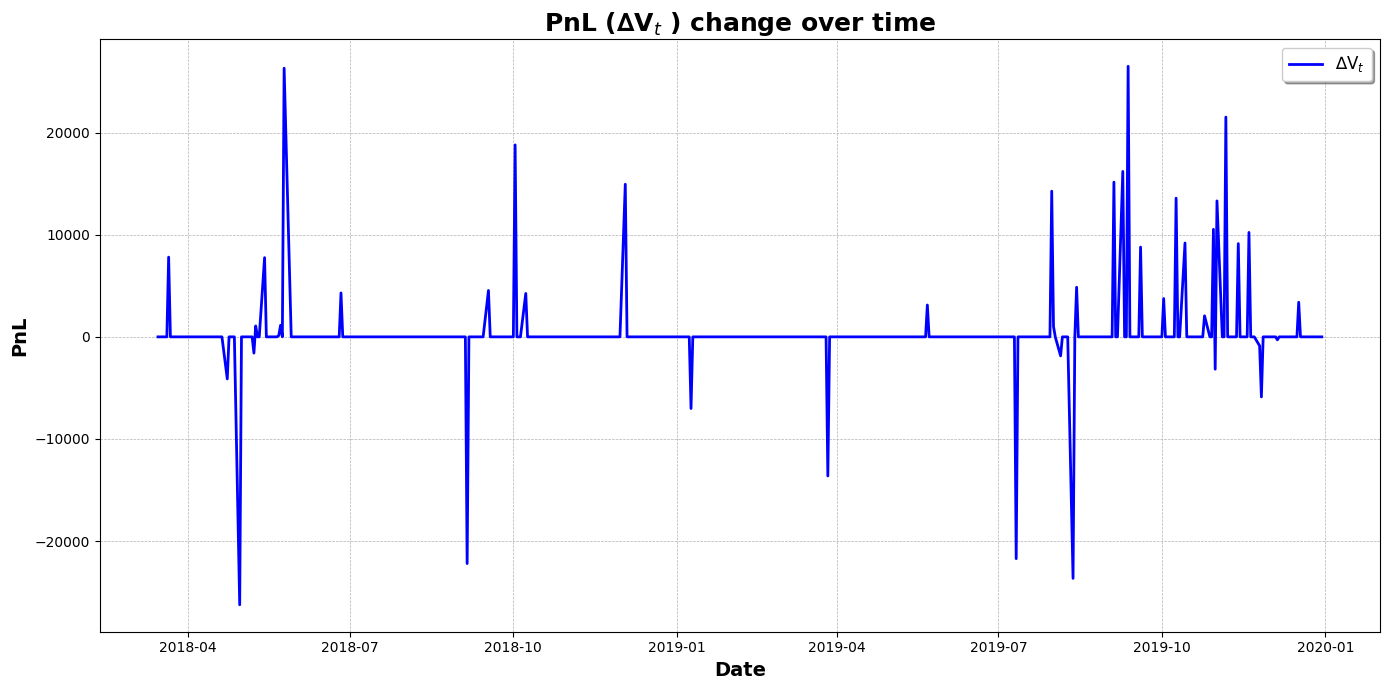

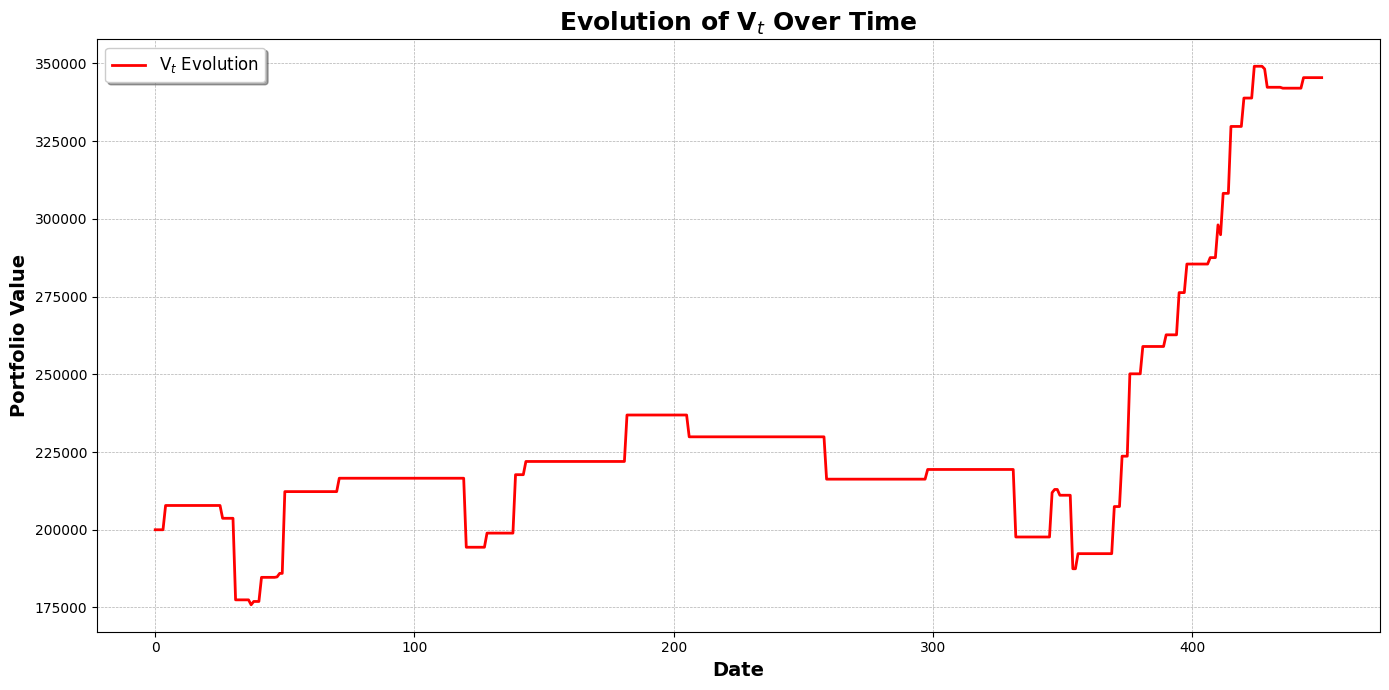

In [21]:
# Plot testing_data['dVt'] over time
plt.figure(figsize=(14, 7))
plt.plot(testing_data['dVt'], label='∆V$_t$', color='blue', linewidth=2)
plt.title('PnL (∆V$_t$ ) change over time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#Plot V0_evolution over time
plt.figure(figsize=(14, 7))
plt.plot(V0_evolution, label='V$_t$ Evolution', color='red', linewidth=2)
plt.title('Evolution of V$_t$ Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



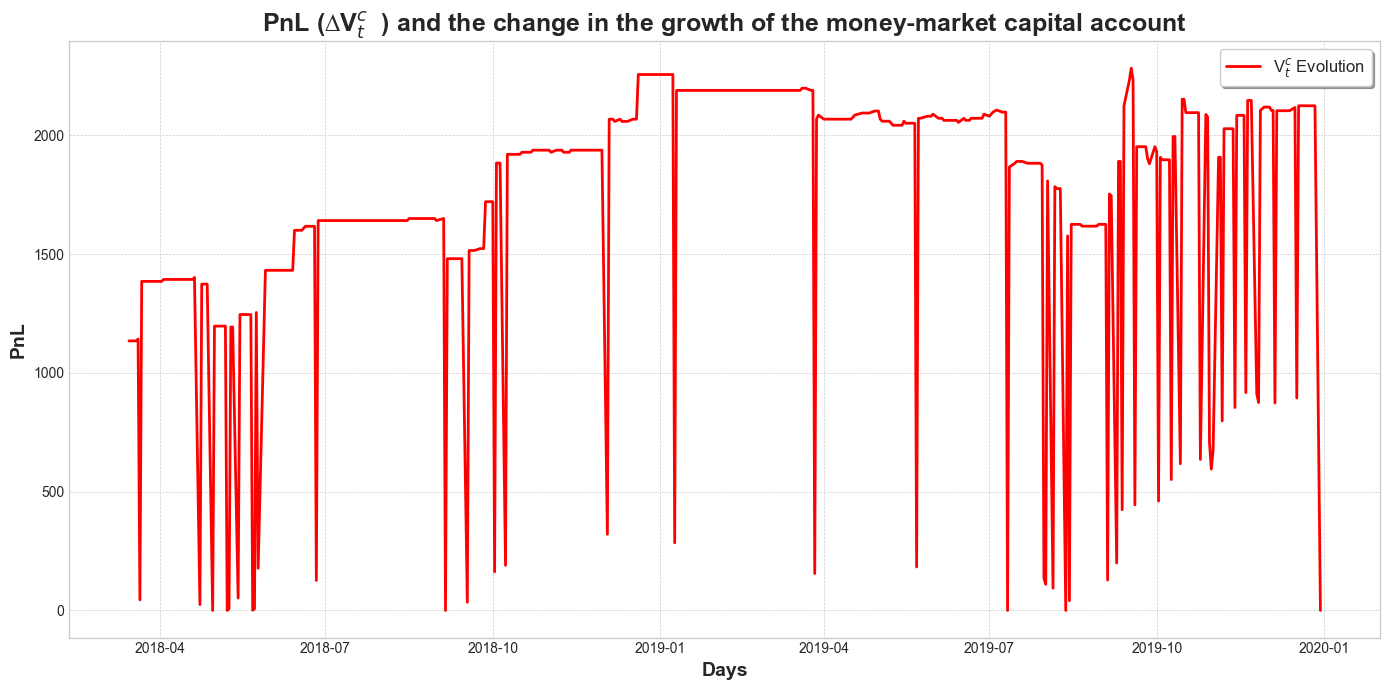

In [22]:
# calculating dVt(cap) over time
testing_data['Mt'] = round((testing_data['Position'].abs()) / L, 0)

testing_data['Extra_Margin'] = testing_data['Vt'] - testing_data['Mt']
#print(sptl_test_data['Extra_Margin'])

testing_data['dVtt'] = (testing_data['Extra_Margin'] * testing_data['EFFR_Adjusted']).clip(lower=0)
#print(sptl_test_data['dVtt'])

# Plotting dVt over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(testing_data['dVtt'], label='V$_t^c$ Evolution', color='red', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('PnL (∆V$_t^c$  ) and the change in the growth of the money-market capital account', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

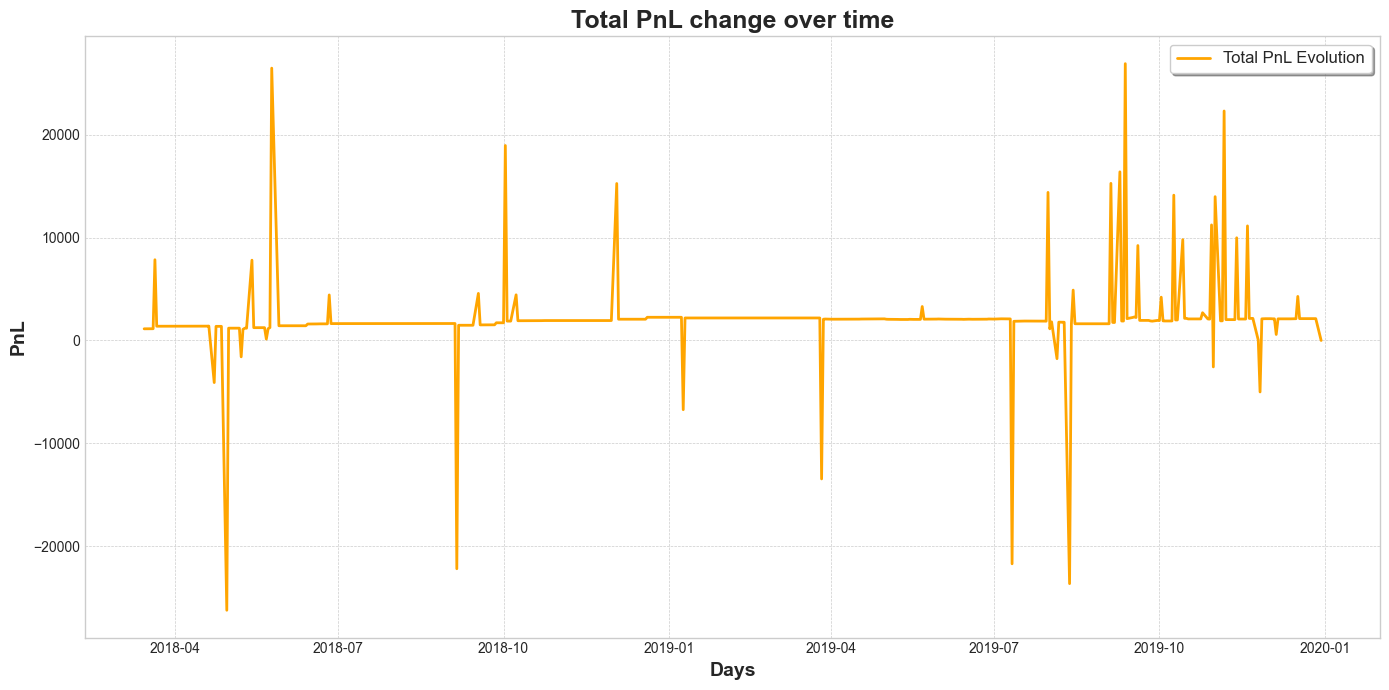

In [23]:
# Total PnL
testing_data['Total_PnL'] = round(testing_data['dVt'] + testing_data['dVtt'],2)


# Plot the total PnL over time
# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the evolution of V0 over time
plt.figure(figsize=(14, 7))
plt.plot(testing_data['Total_PnL'], label='Total PnL Evolution', color='orange', linewidth=2)

# Set titles and labels with adjusted font sizes and weights
plt.title('Total PnL change over time', fontsize=18, fontweight='bold')
plt.xlabel('Days', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

Total Turnover: $3764713.54


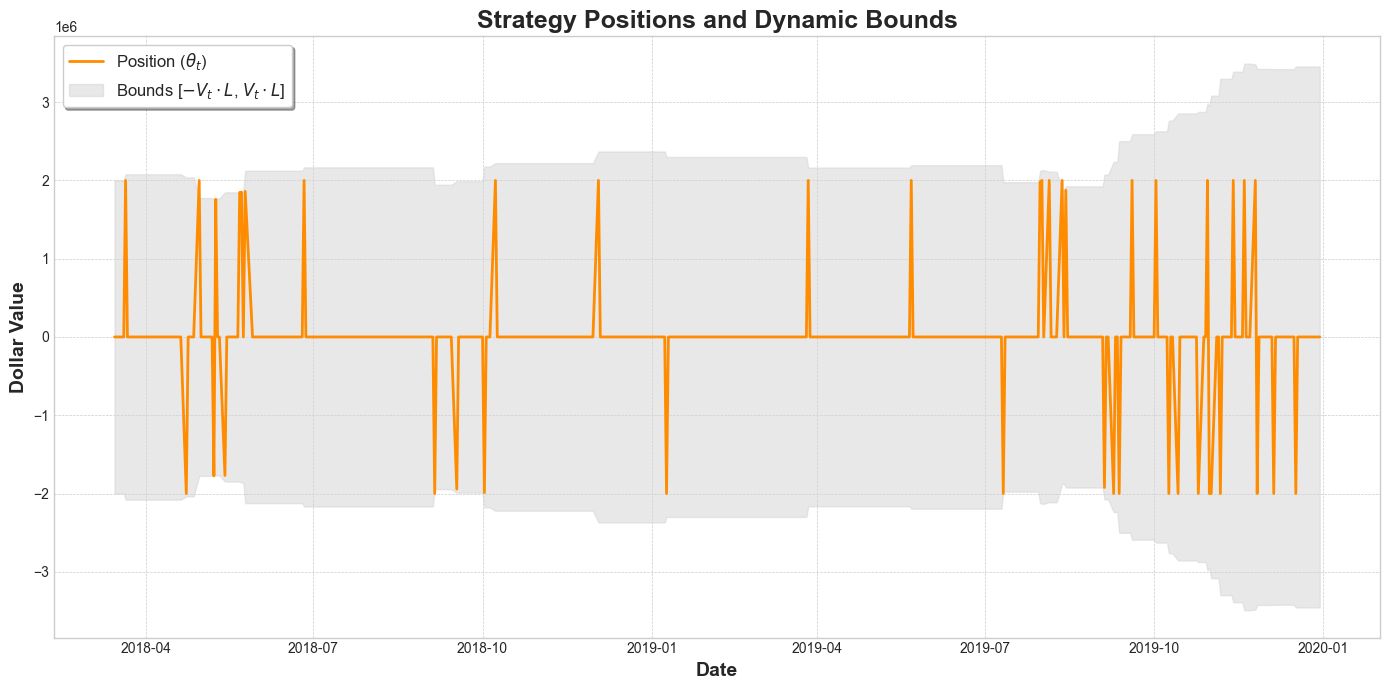

In [24]:

# Calculate and add upper and lower bounds based on V0_evolution
# Calculate the initial lists for upper and lower bounds
upper_bound = [v0 * L for v0 in V0_evolution]
lower_bound = [-v0 * L for v0 in V0_evolution]

# Calculate the difference in lengths
length_difference = len(testing_data) - len(V0_evolution)

# Extend the lists with the last value if there is a length difference
if length_difference > 0:
    upper_bound.extend([upper_bound[-1]] * length_difference)
    lower_bound.extend([lower_bound[-1]] * length_difference)

# Assign the extended lists to the DataFrame
testing_data['Upper_Bound'] = upper_bound
testing_data['Lower_Bound'] = lower_bound

# calculate the total turnover in dollar value traded
total_turnover_1 = abs(testing_data['Position'].sum())
print(f'Total Turnover: ${total_turnover_1:.2f}')

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plotting
plt.figure(figsize=(14, 7))

# Plot positions over time
plt.plot(testing_data.index, testing_data['Position'], label='Position ($\\theta_t$)', color='darkorange', linewidth=2)

# Plot dynamic upper and lower bounds with a fill
plt.fill_between(testing_data.index, testing_data['Lower_Bound'], testing_data['Upper_Bound'], color='lightgray', alpha=0.5, label='Bounds [$-V_t \\cdot L$, $V_t \\cdot L$]')

# Set titles and labels with adjusted font sizes and weights
plt.title('Strategy Positions and Dynamic Bounds', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Dollar Value', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

Total Turnover: $3764713.54
Total Unit Turnover: 4098800.00


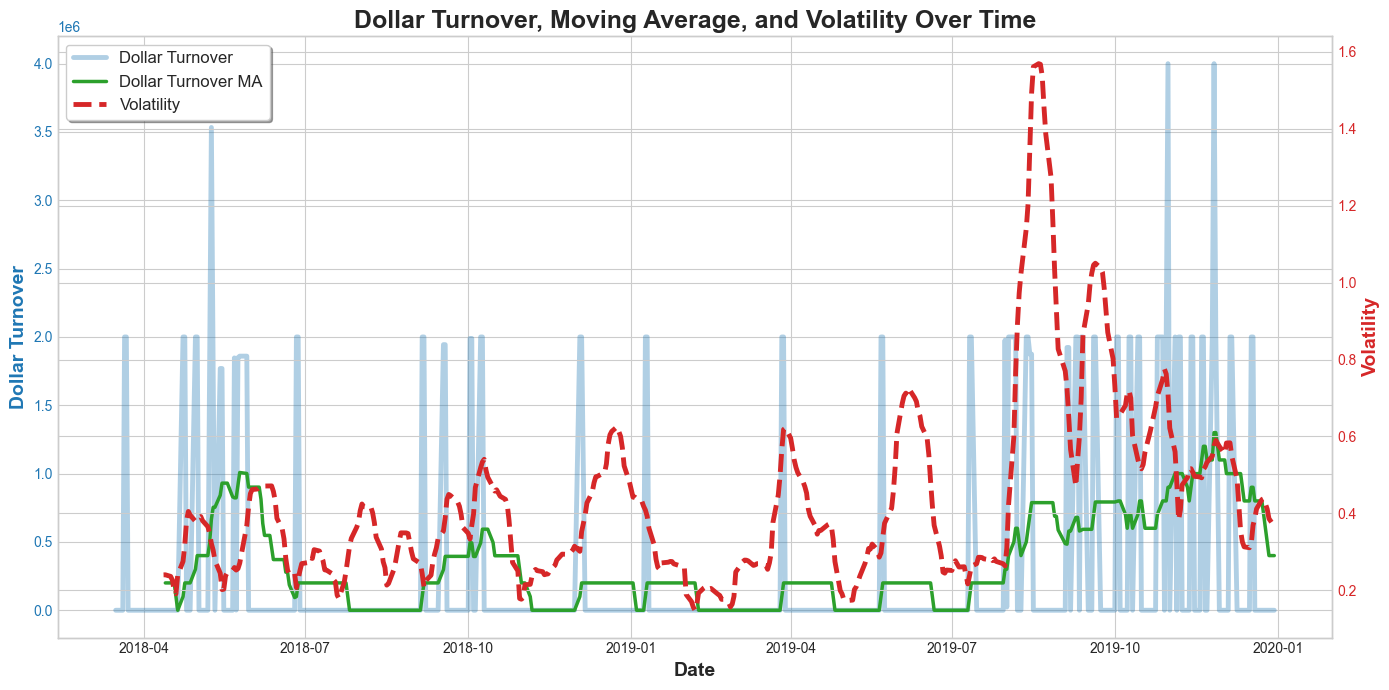

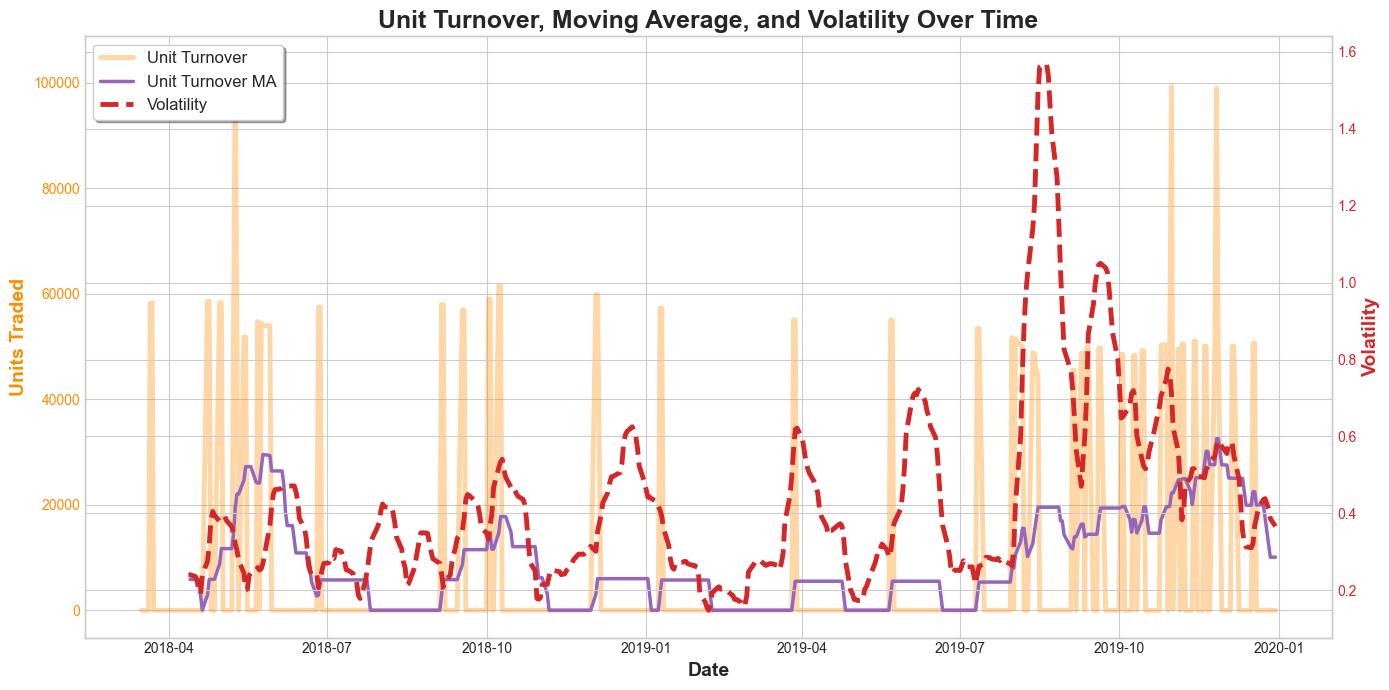

In [25]:
# Calculate the turnover in dollar value traded
testing_data['Dollar_Turnover'] = testing_data['Position'].diff().abs()
# calculate the total turnover in dollar value traded
total_turnover_1 = abs(testing_data['Position'].sum())
print(f'Total Turnover: ${total_turnover_1:.2f}')

# Calculate the unit turnover 
testing_data['Unit_Turnover'] = ((testing_data['Position'].shift(1) / testing_data['Close'].shift(1)) - (testing_data['Position'] / testing_data['Close'])).abs()
# print the total unit turnover
total_unit_turnover = testing_data['Unit_Turnover'].sum()
print(f'Total Unit Turnover: {total_unit_turnover:.2f}')

# Calculate the volatility of the close prices for SPTL
testing_data['Volatility'] = testing_data['Close'].rolling(window=20).std()

# Calculate the moving averages for both Dollar and Unit Turnover
testing_data['Dollar_Turnover_MA'] = testing_data['Dollar_Turnover'].rolling(window=20).mean()
testing_data['Unit_Turnover_MA'] = testing_data['Unit_Turnover'].rolling(window=20).mean()

# Apply the Seaborn style for a clean look
plt.style.use('seaborn-v0_8-whitegrid')

# Dollar Turnover and Volatility with Moving Average Plot
plt.figure(figsize=(14, 7))

# Primary y-axis for Dollar Turnover
color_dollar_turnover = 'tab:blue'
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Dollar Turnover', fontsize=14, fontweight='bold', color=color_dollar_turnover)
line1, = plt.plot(testing_data.index, testing_data['Dollar_Turnover'], label='Dollar Turnover', color=color_dollar_turnover, linewidth=3.5, alpha=0.35)  # Kept transparent
line3, = plt.plot(testing_data.index, testing_data['Dollar_Turnover_MA'], label='Dollar Turnover MA', color='tab:green', linewidth=2.5, linestyle='-')  # Made fully opaque
plt.tick_params(axis='y', labelcolor=color_dollar_turnover)

# Secondary y-axis for Volatility
ax2 = plt.gca().twinx()
color_volatility = 'tab:red'
ax2.set_ylabel('Volatility', fontsize=14, fontweight='bold', color=color_volatility)
line2, = ax2.plot(testing_data.index, testing_data['Volatility'], label='Volatility', color=color_volatility, linestyle='--', linewidth=3.5)  # Made fully opaque
ax2.tick_params(axis='y', labelcolor=color_volatility)

plt.title('Dollar Turnover, Moving Average, and Volatility Over Time', fontsize=18, fontweight='bold')
plt.legend([line1, line3, line2], ['Dollar Turnover', 'Dollar Turnover MA', 'Volatility'], loc='upper left', fontsize=12, frameon=True, shadow=True)
plt.tight_layout()

plt.show()

# Unit Turnover and Volatility with Moving Average Plot
plt.figure(figsize=(14, 7))

# Primary y-axis for Unit Turnover
color_unit_turnover = 'darkorange'
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Units Traded', fontsize=14, fontweight='bold', color=color_unit_turnover)
line1, = plt.plot(testing_data.index, testing_data['Unit_Turnover'], label='Unit Turnover', color=color_unit_turnover, linewidth=3.5, alpha=0.35)  # Kept transparent
line3, = plt.plot(testing_data.index, testing_data['Unit_Turnover_MA'], label='Unit Turnover MA', color='tab:purple', linewidth=2.5, linestyle='-')  # Made fully opaque
plt.tick_params(axis='y', labelcolor=color_unit_turnover)

# Secondary y-axis for Volatility, correctly applying full opacity as in the first plot
ax2 = plt.gca().twinx()
ax2.set_ylabel('Volatility', fontsize=14, fontweight='bold', color=color_volatility)
line2, = ax2.plot(testing_data.index, testing_data['Volatility'], label='Volatility', color=color_volatility, linestyle='--', linewidth=3.5)  # Made fully opaque
ax2.tick_params(axis='y', labelcolor=color_volatility)

plt.title('Unit Turnover, Moving Average, and Volatility Over Time', fontsize=18, fontweight='bold')
plt.legend([line1, line3, line2], ['Unit Turnover', 'Unit Turnover MA', 'Volatility'], loc='upper left', fontsize=12, frameon=True, shadow=True)
plt.tight_layout()

plt.show()


In [26]:
# TEST DATA METRICS
# Annualization factor
annualization_factor = np.sqrt(252)

# Sharpe Ratio (Annualized)
test_sharpe_ratio_annualized = (testing_data['dVt'].mean() * annualization_factor) / (testing_data['dVt'].std() * annualization_factor)
print(f'Sharpe Ratio (Annualized): {test_sharpe_ratio_annualized:.4f}')
# Sortino Ratio (Annualized)
downside_returns = testing_data['dVt'][testing_data['dVt'] < 0]
downside_std = downside_returns.std()
test_sortino_ratio_annualized = (testing_data['dVt'].mean() * annualization_factor) / downside_std
print(f'Sortino Ratio (Annualized): {test_sortino_ratio_annualized:.4f}')
# Maximum Drawdown (No annualization needed)
cumulative_pnl = testing_data['dVt'].cumsum()
cumulative_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - cumulative_max
max_drawdown = drawdown.min()
print(f'Maximum Drawdown: {max_drawdown:.2f}')
# Calmar Ratio (Annualized)
calmar_ratio_annualized = (testing_data['dVt'].mean() * annualization_factor) / abs(max_drawdown)
print(f'Calmar Ratio (Annualized): {calmar_ratio_annualized:.4f}')

Sharpe Ratio (Annualized): 0.0837
Sortino Ratio (Annualized): 0.5172
Maximum Drawdown: -49457.69
Calmar Ratio (Annualized): 0.1033


/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2123140125.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Vt'].iloc[0] = V0
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2123140125.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['dVt'].iloc[i] = theta * daily_return * training_data['Close'].iloc[i]
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2123140125.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

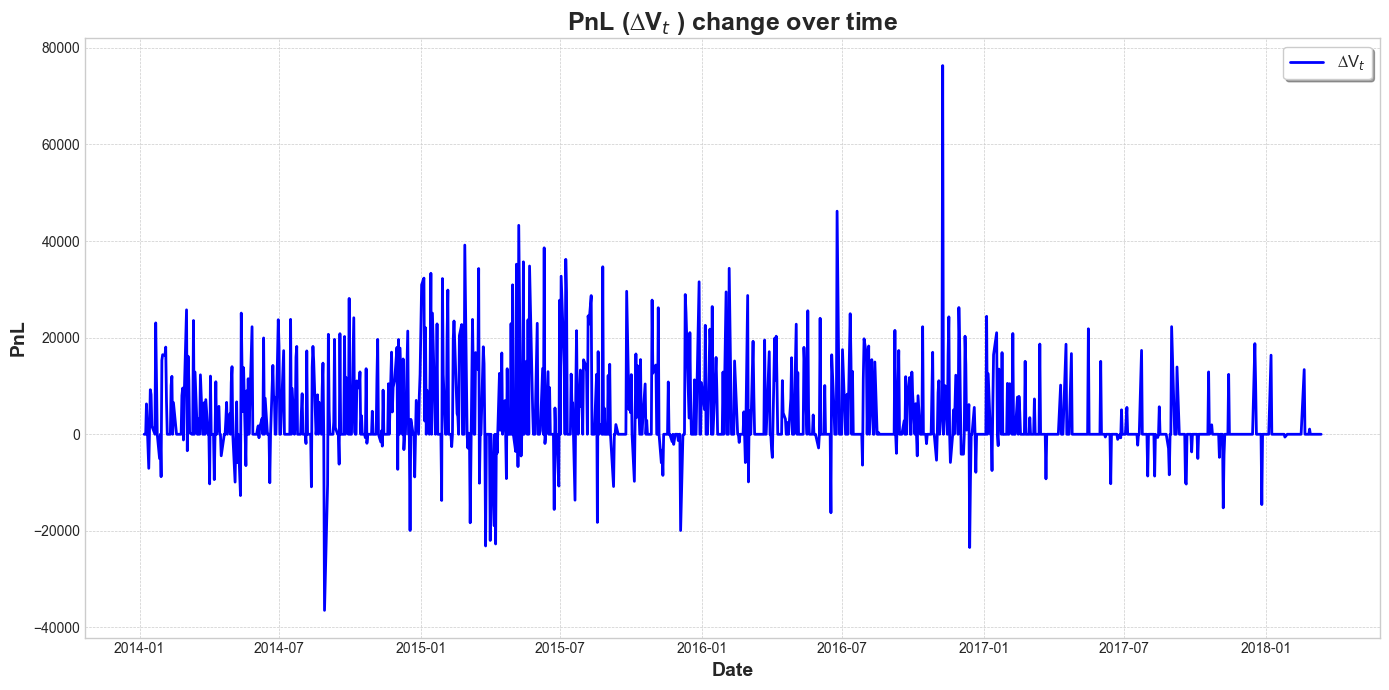

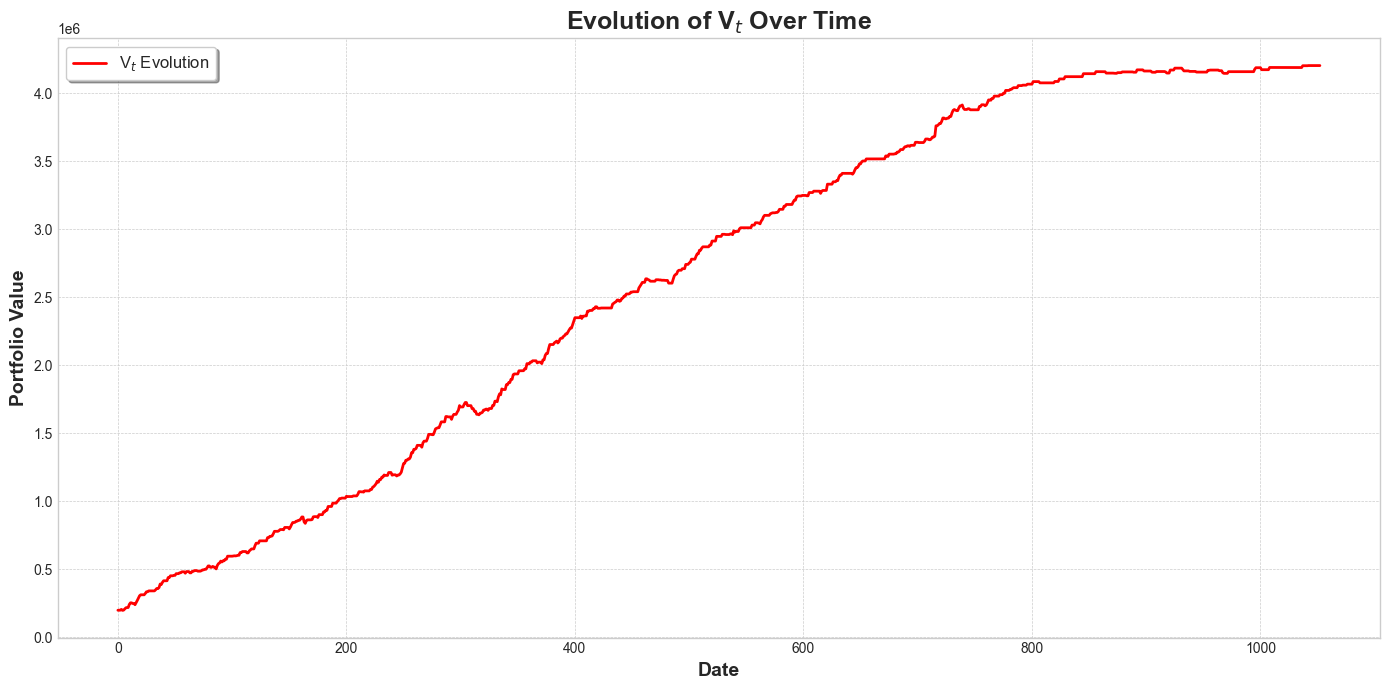

In [27]:
# Initialize trading parameters and variables
V0 = 200000.00  # Initial capital
L = 10  # Leverage
maximum_dollar_value = V0 * L  # Maximum dollar value that can be held
training_data['dVt'] = 0.0  # Initialize the daily PnL
theta = 0  # No position initially
V0_evolution = [V0]  # Store the evolution of V0 over time
upper_bound = [0]
lower_bound = [0]
training_data['Position'] = 0
training_data['Vt'] = 0
training_data['Vt'].iloc[0] = V0

for i in range(1, len(training_data)-1):  # Adjust loop to prevent index out of bounds
    upper_bound.append(V0 * L)
    lower_bound.append(-V0 * L)
    
    if training_data['Signal'].iloc[i] == 1:  # Adjusted for comparison with integer
        theta = round((maximum_dollar_value / training_data['Close'].iloc[i]))
        daily_return = training_data['Daily_Returns'].iloc[i] - training_data['EFFR_Adjusted'].iloc[i]
    elif training_data['Signal'].iloc[i] == -1:  # Adjusted for comparison with integer
        theta = -round((maximum_dollar_value / training_data['Close'].iloc[i]))
        daily_return = training_data['Daily_Returns'].iloc[i] + training_data['EFFR_Adjusted'].iloc[i]
    else:
        theta = 0
        daily_return = 0  # Ensures daily_return is reset for non-trading days
    
    # Update PnL based on the position from the previous day
    training_data['dVt'].iloc[i] = theta * daily_return * training_data['Close'].iloc[i]
    
    # Update the capital with the daily PnL
    V0 += training_data['dVt'].iloc[i]
    V0 = max(V0, 0)  # Ensure that the capital does not go negative
    maximum_dollar_value = min(V0 * L, 200000 * L)
    
    V0_evolution.append(V0)
    training_data['Position'].iloc[i] = theta * training_data['Close'].iloc[i]  # Update position
    training_data['Vt'].iloc[i] = V0


# Plot training_data['dVt'] over time
plt.figure(figsize=(14, 7))
plt.plot(training_data['dVt'], label='∆V$_t$', color='blue', linewidth=2)
plt.title('PnL (∆V$_t$ ) change over time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('PnL', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#Plot V0_evolution over time
plt.figure(figsize=(14, 7))
plt.plot(V0_evolution, label='V$_t$ Evolution', color='red', linewidth=2)
plt.title('Evolution of V$_t$ Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

#training data to excel
#training_data.to_excel('testing_data_with_signals.xlsx', index=False)

In [28]:
# TRAIN DATA METRICS
# Annualization factor
annualization_factor = np.sqrt(252)

# Sharpe Ratio (Annualized)
test_sharpe_ratio_annualized = (training_data['dVt'].mean() * annualization_factor) / (training_data['dVt'].std() * annualization_factor)
print(f'Sharpe Ratio (Annualized): {test_sharpe_ratio_annualized:.4f}')
# Sortino Ratio (Annualized)
downside_returns = training_data['dVt'][training_data['dVt'] < 0]
downside_std = downside_returns.std()
test_sortino_ratio_annualized = (training_data['dVt'].mean() * annualization_factor) / downside_std
print(f'Sortino Ratio (Annualized): {test_sortino_ratio_annualized:.4f}')
# Maximum Drawdown (No annualization needed)
cumulative_pnl = training_data['dVt'].cumsum()
cumulative_max = cumulative_pnl.cummax()
drawdown = cumulative_pnl - cumulative_max
max_drawdown = drawdown.min()
print(f'Maximum Drawdown: {max_drawdown:.2f}')
# Calmar Ratio (Annualized)
calmar_ratio_annualized = (training_data['dVt'].mean() * annualization_factor) / abs(max_drawdown)
print(f'Calmar Ratio (Annualized): {calmar_ratio_annualized:.4f}')

Sharpe Ratio (Annualized): 0.4078
Sortino Ratio (Annualized): 9.2078
Maximum Drawdown: -90648.74
Calmar Ratio (Annualized): 0.6649


/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2748397694.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training_data['dVt'] = training_data['dVt'].fillna(method='ffill')
/var/folders/tv/bjxgwfxn7578_3m4cl8608dm0000gn/T/ipykernel_7053/2748397694.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  testing_data['dVt'] = testing_data['dVt'].fillna(method='ffill')  # Assuming test_data is your test dataset


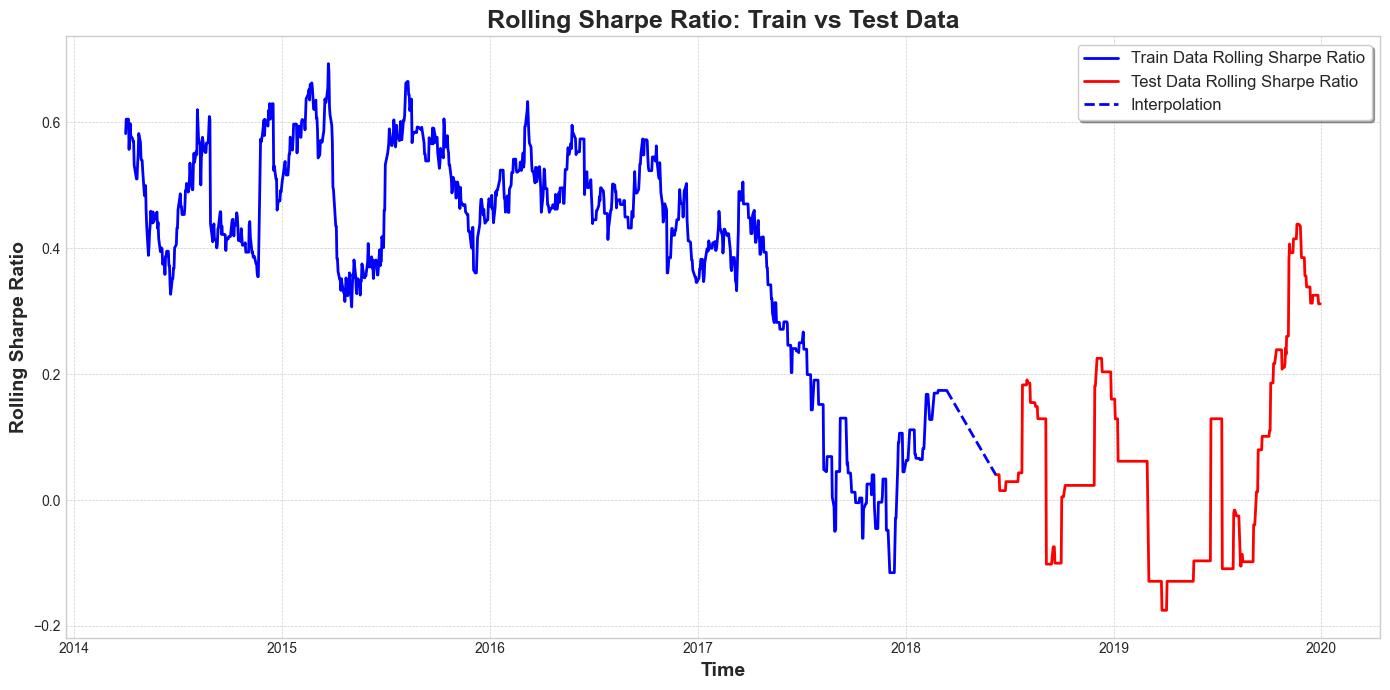

In [33]:
# Filling missing values with the previous valid value
training_data['dVt'] = training_data['dVt'].fillna(method='ffill')
testing_data['dVt'] = testing_data['dVt'].fillna(method='ffill')  # Assuming test_data is your test dataset

# Calculate the rolling Sharpe ratio for the train data
rolling_sharpe_ratio_train = training_data['dVt'].rolling(window=60).mean() / training_data['dVt'].rolling(window=60).std()

# Calculate the rolling Sharpe ratio for the test data  
rolling_sharpe_ratio_test = testing_data['dVt'].rolling(window=60).mean() / testing_data['dVt'].rolling(window=60).std()  # Use test_data here

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Plot the Rolling Sharpe Ratio for both Train and Test Data
plt.figure(figsize=(14, 7))
train_plot = plt.plot(rolling_sharpe_ratio_train, label='Train Data Rolling Sharpe Ratio', color='blue', linewidth=2)
test_plot = plt.plot(rolling_sharpe_ratio_test, label='Test Data Rolling Sharpe Ratio', color='red', linewidth=2)

# Get the last point of the training data
last_train_point = rolling_sharpe_ratio_train.last_valid_index()
# Get the first point of the test data
first_test_point = rolling_sharpe_ratio_test.first_valid_index()

# Connect the last point of training data to the first point of the test data
if pd.notnull(last_train_point) and pd.notnull(first_test_point):
    plt.plot([last_train_point, first_test_point],
             [rolling_sharpe_ratio_train[last_train_point], rolling_sharpe_ratio_test[first_test_point]],
             color='blue', linestyle='--', linewidth=2, label='Interpolation')

# Set titles and labels with adjusted font sizes and weights
plt.title('Rolling Sharpe Ratio: Train vs Test Data', fontsize=18, fontweight='bold')
plt.xlabel('Time', fontsize=14, fontweight='bold')
plt.ylabel('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')

# Adjust legend appearance
plt.legend(fontsize=12, frameon=True, shadow=True)

# Ensure the grid is enabled for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing and save the figure if needed
plt.tight_layout()

# Display the plot
plt.show()

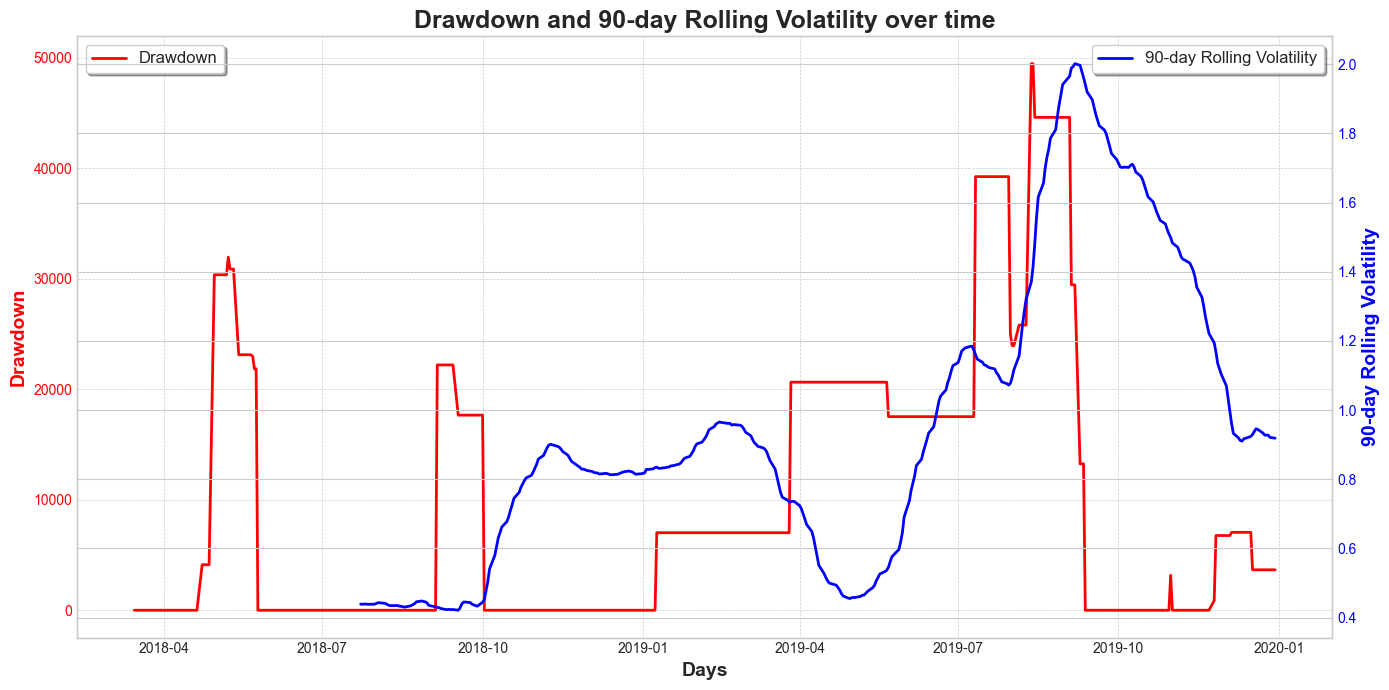

In [30]:
# Calculate the drawdown over time and the historic rolling 90-day volatility of the underlying asset for the test set
# Calculate the cumulative PnL
testing_data['Cumulative_PnL'] = testing_data['dVt'].cumsum()

# Calculate the rolling maximum of the cumulative PnL to represent the peak
testing_data['Rolling_Max_PnL'] = testing_data['Cumulative_PnL'].cummax()

# Calculate the Drawdown
testing_data['Drawdown'] = testing_data['Rolling_Max_PnL'] - testing_data['Cumulative_PnL']



# Calculate the historic rolling 90-day volatility of the closing prices
testing_data['Volatility'] = testing_data['Close'].rolling(window=90).std()

# Apply the Seaborn style for a nicer look
plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and the first axis for the Drawdown
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Drawdown on the first axis
ax1.plot(testing_data.index, testing_data['Drawdown'], label='Drawdown', color='red', linewidth=2)
ax1.set_xlabel('Days', fontsize=14, fontweight='bold')
ax1.set_ylabel('Drawdown', color='red', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='red')
ax1.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)

# Create a second axis for the volatility shared x-axis with the first axis
ax2 = ax1.twinx()
ax2.plot(testing_data.index, testing_data['Volatility'], label='90-day Rolling Volatility', color='blue', linewidth=2)
ax2.set_ylabel('90-day Rolling Volatility', color='blue', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)

# Set title and grid
plt.title('Drawdown and 90-day Rolling Volatility over time', fontsize=18, fontweight='bold')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
fig.tight_layout()

# Display the plot
plt.show()